# Analyse relation of input parameters to predicted dmg by RF


In [1]:
import os
import rioxarray as rioxr
import xarray as xr
# import cftime

import re
import dask
import pandas as pd 
import geopandas as gpd
# import matplotlib.pyplot as plt
import numpy as np
import glob
# import matplotlib.patches as mpatches
# from sklearn.metrics import r2_score
# import numpy.polynomial.polynomial as poly

# import rasterio as rio

# import pandas as pd 

# import seaborn as sns

# Import user functions
# get_tilelist_region, load_tile_yxt, clip_da_to_iceshelf, 
# load_tiles_region_multiyear, aggregate_region_ds_iceshelf , 
# remove_nanpx_multivar, fill_nan_cdata, reproject_match_grid
# import myFunctions as myf 
import nbFunctions as myf

homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'


## Load observational data to find min-max ranges

In [3]:

def load_nc_sector_years( path2data, sector_ID, year_list=None, varName=None ):
    ''' Load all/selected annual netCDF files of a variable for one sector'''

    ## get filelist of variable for current sector
    filelist_dir =  glob.glob( os.path.join(path2data, f'*_sector-{sector_ID}_*.nc') )
    filelist_var_all = [file for file in filelist_dir if varName in file]
    filelist_var_all.sort()

    ## select files for all/specified years 
    if year_list is None: # all years
        ## load list of files
        filenames = [os.path.basename(file) for file in filelist_var_all]
        ## retrieve available years from filenames
        year_list = [int( re.search(r'\d{4}', file).group()) for file in filenames]
        filelist_var = filelist_var_all.copy()

    else: # filter filelist for desired year
        filelist_var=[]
        for year in year_list:
            filelist_yr = [file for file in filelist_var_all if str(year) in os.path.basename(file)]
            # print(filelist_yr)
            if not filelist_yr:
                raise ValueError(f'Could not find year {year}')
            filelist_var.append(filelist_yr)

    ## Open dataset(s)

    try: # read all years at once
        region_ds = (xr.open_mfdataset(filelist_var ,
                    combine='nested', concat_dim='time',
                    compat='no_conflicts',
                    preprocess=myf.drop_spatial_ref)
            .rio.write_crs(3031,inplace=True)
            .assign_coords(time=year_list) # update year values (y,x,time)
        )
    except ValueError: # read year by year, then concatenate
        region_list = []
        for file in filelist_var:
            yr = int( re.search(r'\d{4}', os.path.basename(file[0])).group()) 
            # print(yr)
            with xr.open_mfdataset(file) as ds:
                try:
                    ds.assign_coords(time=yr)
                except: pass
                region_list.append(ds.rio.write_crs(3031,inplace=True))
        region_ds = xr.concat(region_list,dim='time')  
        # print(region_ds.coords) 
    return region_ds

def downsample_obs_data(region_ds,ksize):
    dx = int(region_ds.rio.resolution()[0])
    dy = int(region_ds.rio.resolution()[1])
    if np.abs(dx) != np.abs(dy):
        print("Warning: x and y resolution are not the same; {} and {} -- code update required".format(np.abs(dx), np.abs(dy) ))

    # with dask.config.set(**{'array.slicing.split_large_chunks': True}): # gives error?
    with dask.config.set(**{'array.slicing.split_large_chunks': False}): ## accept large chunks; ignore warning
        region_ds = myf.downsample_dataArray_withoutD0(region_ds, ksize=ksize, 
                                    boundary_method='pad',downsample_func='mean', skipna=False)
    new_res = ksize*400
    print('.. resolution {}m downsampled to {}m'.format(dx, new_res))


    # Check if grid resolution is regular (otherwise, adjust)
    if np.abs(int(region_ds.rio.resolution()[0]) ) != np.abs( int(region_ds.rio.resolution()[1]) ):
        print( "x and y resolution are not the same; {} and {} -- resample to regular grid of {}m".format(
                    np.abs(int(region_ds.rio.resolution()[0])), 
                    np.abs(int(region_ds.rio.resolution()[1])), new_res ))
        
        grid_dummy = myf.make_regular_grid_for_ds(region_ds, grid_res=new_res)
        region_ds.rio.write_crs(3031, inplace=True)
        region_ds = myf.reproject_match_grid( grid_dummy, region_ds )         
    return region_ds

In [4]:

''' ----------------------
Load data: shapefiles 
------------------------- '''
# sectors of interest for AIS

sector_path = os.path.join(homedir, 'QGis/data_NeRD/AIS_outline_sectors.shp')
sector_poly = gpd.read_file(sector_path)
sector_ID_list = sector_poly['sector_ID'].to_list()
sector_ID_list.sort()
sector_ID_list

sector_ID_list = ['ASE', 'BSE', 'EIS', 'RS', 'WIS-a', 'WIS-b', 'WS']

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_poly_meas = gpd.read_file(iceshelf_path_meas)
iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE'],axis=1)

In [5]:
sector_ID_list

['ASE', 'BSE', 'EIS', 'RS', 'WIS-a', 'WIS-b', 'WS']

In [7]:

## data settings
path2data = os.path.join(homedir, 'Data/NERD/data_predictor/data_sector/velocity_rema/')
year_list=['2015','2016','2017','2018']
# year_list=['2019','2020','2021']

# ksize=None
# length_scales = ['1px','5px']#,'15px']
ksize = 20
length_scales = ['1px']



''' ----------------------
Load data: netCDFs per region, per variable
------------------------- '''

region_ds_list = []
df_min_list=[]
df_max_list=[]
for sector_ID in sector_ID_list: 

    print('----\n Loading netCDF for region ', sector_ID)


    ''' -------------------
    Load all variables from individual netCDF files 
    Expecting data directory to contain netCDFs per sector per training variable per year. 
    ----------------------- '''
    region_ds_varlist=[]
    for var in ['vx','vy']: # base variables to read, from which all other training features are calculated
        region_var = load_nc_sector_years( path2data, sector_ID, varName=var, year_list=year_list) # load all available years
        region_ds_varlist.append(region_var)
    # load rema (only 1 year)
    region_var = load_nc_sector_years( path2data, sector_ID, varName='rema', year_list=['0000']) # , year_list=years_train)
    region_ds_varlist.append(region_var)
    # combine to single dataset
    region_ds = xr.combine_by_coords(region_ds_varlist)
    print('Loaded variables: \n', list(region_ds.keys()) )#, region_ds.coords)
    

    ''' --------------------------------------
    Repeat temporally static variable (REMA) to even out dataset dimension
    This drops time=0
    ------------------------------------------ '''

    region_ds = myf.repeat_static_variable_timeseries( region_ds , 'rema' )
    


    ''' ----------------
    Downsample observation data ( 400m to 8000m )
    --------------------'''

    if ksize:
        downsample_obs_data(region_ds, ksize)


    ''' ------------
    Calculate velocity and strain for (downsampled) data
    ---------------- '''
    # calculate velocity, strain components and temporal velo/strain change
    for lscale in length_scales:
            
        data_velo_strain, region_ds_roll = myf.calculate_velo_strain_features(region_ds, 
                                                    velocity_names=('vx','vy'), 
                                                    length_scales=[lscale])
        region_ds = xr.merge([region_ds, data_velo_strain])
        region_ds = xr.merge([region_ds, region_ds_roll])


    ''' --------------------------------------
    Clip to ice shelf
    ------------------------------------------ '''

    ''' Clip to iceshelf '''
    iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE'],axis=1)
    region_ds  = region_ds.rio.clip( iceshelf_polygon_gpd.geometry, iceshelf_polygon_gpd.crs, drop=False, invert=False)

    region_ds_list.append(region_ds)



----
 Loading netCDF for region  ASE
Loaded variables: 
 ['rema', 'vx', 'vy']
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7979 and 7991 -- resample to regular grid of 8000m
.. calculated strain variables  ['emax_1px', 'emin_1px', 'e_eff_1px', 'elon_1px', 'etrans_1px', 'eshear_1px']
----
 Loading netCDF for region  BSE
Loaded variables: 
 ['rema', 'vx', 'vy']
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7979 and 7984 -- resample to regular grid of 8000m
.. calculated strain variables  ['emax_1px', 'emin_1px', 'e_eff_1px', 'elon_1px', 'etrans_1px', 'eshear_1px']
----
 Loading netCDF for region  EIS
Loaded variables: 
 ['rema', 'vx', 'vy']
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7999 and 7990 -- resample to regular grid of 8000m
.. calculated strain variables  ['emax_1px', 'emin_1px', 'e_eff_1px', 'e

### aggregate & save csv

In [8]:
len(region_ds_list)

7

In [9]:

# xvar_list=['time','vx','vy','rema', 'v', 'emax_1px', 'emin_1px', 'e_eff_1px', 'elon_1px', 'etrans_1px', 'eshear_1px', 'dEmax_1px', 'deltaV']
xvar_list = list( region_ds.data_vars )

data_pxs_df_list=[]
for sector_ID,region_ds in zip(sector_ID_list,region_ds_list): 
    ''' ----------------
    Convert to dataFrame
    --------------------'''

    ''' Aggregate to 1D '''
    region_ds_1d = region_ds.stack(samples=['x','y']) # (time, samples)
    data_pxs_df = region_ds_1d.to_dataframe() # nested dataframe
    data_pxs_df = data_pxs_df.rename(columns={"x": "x_coord", "y": "y_coord"}) # rename the column so that flattening the multi-index in the next step does not give an error (relevant for  pandas version > 1.4.3)

    # Flatten the nested multi-index to just column values -- automatically generates a 'year' value for every sample
    data_pxs_df = data_pxs_df.reset_index(level=['time','x','y']) # 18767504 rows; 
    
    # # Drop spatial ref (has not data acutally) 
    data_pxs_df = data_pxs_df.drop(['spatial_ref'],axis=1)

    # print(data_pxs_df.columns)
    # raise RuntimeError
    ''' ----------------
    Drop NaN pixels:
    Pandas drops all rows that contain missing values. 
    - This means that if any variable has a NaN value, that px is dropped.
        So make sure to fill NaN values for variables before this step iif needed (filling gaps etc) 
    - Since I have rows for px per year, this means that if I would have clipped the data to annual ice shelf polygons, the number of pixels per year can vary.  
    -------------------- '''

    # print('.. dropping {} rows with any NaN value'.format( data_pxs_df.isna().sum(axis='index').max() ))
    data_pxs_df.dropna(subset=xvar_list, axis='index',inplace=True) # Drop rows which contain missing values.

    ### SAVE TO CSV
    # if ksize is None:
    filename = f'data_RFinput_pxs_{sector_ID}_{ksize}x{ksize}_{year_list[0]}-{year_list[-1]}.csv'
    if not os.path.isfile(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename)):
        print('.. saving ', filename)
        data_pxs_df.dropna(subset=xvar_list, axis='index').to_csv(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename) , index=False) 

    else:
        data_pxs_df['sector_ID'] = sector_ID
        data_pxs_df_list.append(data_pxs_df)

### save AIS wide to CSV
if ksize is not None:
    data_pxs_ais = pd.concat(data_pxs_df_list)

    ### SAVE TO CSV

    filename = f'data_RFinput_pxs_AIS_{ksize}x{ksize}_{year_list[0]}-{year_list[-1]}.csv'
    print(filename)
    if not os.path.isfile(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename)):
        print('.. saving ', filename)
        data_pxs_ais.dropna(subset=xvar_list, axis='index').to_csv(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename) , index=False) 


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


.. saving  data_RFinput_pxs_ASE_20x20_2015-2018.csv


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


.. saving  data_RFinput_pxs_BSE_20x20_2015-2018.csv


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


.. saving  data_RFinput_pxs_EIS_20x20_2015-2018.csv
.. saving  data_RFinput_pxs_RS_20x20_2015-2018.csv
.. saving  data_RFinput_pxs_WIS-a_20x20_2015-2018.csv
.. saving  data_RFinput_pxs_WIS-b_20x20_2015-2018.csv


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [40]:
data_pxs_df.dropna(subset=xvar_list, axis='index')

,time,x,y,vx,vy,rema,v,emax_1px,emin_1px,e_eff_1px,elon_1px,etrans_1px,eshear_1px,dEmax_1px,deltaV
6164744,2016,-1874600.0,-416600.0,-20.109259,-162.907898,0.279028,164.144348,0.005800,0.000030,0.005815,0.004767,0.001063,-0.002212,0.002890,16.310730
6164745,2016,-1874600.0,-416200.0,-20.126627,-161.707092,0.372496,162.954803,0.004712,-0.000285,0.004576,0.003559,0.000868,-0.002106,0.002199,10.771133
6164746,2016,-1874600.0,-415800.0,-20.184660,-158.726562,0.456637,160.004822,0.007863,0.000620,0.008191,0.007769,0.000714,-0.000820,0.006338,-2.216934
6164747,2016,-1874600.0,-415400.0,-20.240080,-155.558838,0.648992,156.870056,0.008010,0.000676,0.008368,0.008007,0.000678,0.000133,0.006740,-16.381332
6164748,2016,-1874600.0,-415000.0,-20.272387,-154.198792,0.795611,155.525681,0.003475,0.000609,0.003816,0.003472,0.000611,-0.000090,0.002177,-23.409225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23913528,2018,-1102600.0,-1187800.0,-489.374237,-808.390076,44.999996,944.977051,-0.009920,-0.025481,0.031630,-0.020481,-0.014919,-0.007267,-0.001439,84.027771
23913529,2018,-1102600.0,-1187400.0,-536.691162,-812.054993,50.894073,973.381104,0.016746,-0.037684,0.032703,-0.034965,0.014027,0.011858,0.005778,71.990540
23916303,2018,-1102200.0,-1203400.0,96.746506,-164.484558,0.317668,190.827286,0.039348,-0.027611,0.034988,0.002901,0.008836,0.033347,0.000333,7.618729
23919117,2018,-1101800.0,-1203400.0,111.614517,-164.130630,0.132195,198.485931,0.037314,-0.004517,0.035273,0.006487,0.026309,0.018418,0.004991,17.121964


## load DMG 

In [33]:

## data settings

path2data = os.path.join(homedir, 'Data/NERD/data_predictor/data_sector/damage095/')

year_list=['2015','2016','2017','2018']
year_list=['2019','2020','2021']

ksize=None
ksize=20

''' ----------------------
Load data: netCDFs per region, per variable
------------------------- '''

region_dmg_list = []
data_pxs_dmg_list=[]
for sector_ID in sector_ID_list: 

    print('----\n Loading netCDF for region ', sector_ID)


    ''' -------------------
    Load all variables from individual netCDF files 
    Expecting data directory to contain netCDFs per sector per training variable per year. 
    ----------------------- '''
    
    region_dmg = load_nc_sector_years( path2data, sector_ID, varName='dmg', year_list=year_list) # load all available years

    # print('Loaded variables: \n', list(region_dmg.keys()) )#, region_ds.coords)
    

    ''' ----------------
    Downsample observation data ( 400m to 8000m )
    --------------------'''
    
    if ksize:
        downsample_obs_data(region_dmg, ksize)

    ''' --------------------------------------
    Clip to ice shelf
    ------------------------------------------ '''

    ''' Clip to iceshelf '''
    iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE'],axis=1)
    region_dmg  = region_dmg.rio.clip( iceshelf_polygon_gpd.geometry, iceshelf_polygon_gpd.crs, drop=False, invert=False)

    region_dmg_list.append(region_dmg)


    ''' ----------------
    Convert to dataFrame
    --------------------'''

    ''' Aggregate to 1D '''
    region_ds_1d = region_dmg.stack(samples=['x','y']) # (time, samples)
    data_pxs_dmg = region_ds_1d.to_dataframe() # nested dataframe
    data_pxs_dmg = data_pxs_dmg.rename(columns={"x": "x_coord", "y": "y_coord"}) # rename the column so that flattening the multi-index in the next step does not give an error (relevant for  pandas version > 1.4.3)

    # Flatten the nested multi-index to just column values -- automatically generates a 'year' value for every sample
    data_pxs_dmg = data_pxs_dmg.reset_index(level=['time','x','y']) # 18767504 rows; 
    data_pxs_dmg = data_pxs_dmg.drop(['spatial_ref'],axis=1) # Drop spatial ref (has not data acutally) 

    ''' ----------------
    Drop NaN pixels:
    Pandas drops all rows that contain missing values. 
    - This means that if any variable has a NaN value, that px is dropped.
        So make sure to fill NaN values for variables before this step iif needed (filling gaps etc) 
    - Since I have rows for px per year, this means that if I would have clipped the data to annual ice shelf polygons, the number of pixels per year can vary.  
    -------------------- '''

    # print('.. dropping {} rows with any NaN value'.format( data_pxs_df.isna().sum(axis='index').max() ))
    data_pxs_dmg.dropna( axis='index',inplace=True) # Drop rows which contain missing values.

    # ### SAVE TO CSV
    if ksize:
        filename = f'data_pxs_dmg095_{sector_ID}_{ksize}x{ksize}_{year_list[0]}-{year_list[-1]}.csv'
    else:
        filename = f'data_pxs_dmg095_{sector_ID}_0x0_{year_list[0]}-{year_list[-1]}.csv'

    if not os.path.isfile(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename)):
        print('.. saving ', filename)
        data_pxs_dmg.dropna(axis='index').to_csv(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename) , index=False) 

    data_pxs_dmg_list.append(data_pxs_dmg)
    

# if ksize is not None:
data_pxs_dmg_ais = pd.concat(data_pxs_dmg_list)


### SAVE TO CSV
if ksize:
        filename = f'data_pxs_dmg095_AIS_{ksize}x{ksize}_{year_list[0]}-{year_list[-1]}.csv'
else:
    filename = f'data_pxs_dmg095_AIS_0x0_{year_list[0]}-{year_list[-1]}.csv'
# filename = f'data_pxs_dmg095_AIS_{ksize}x{ksize}_{year_list[0]}-{year_list[-1]}.csv'
if not os.path.isfile(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename)):
    print('.. saving ', filename)
    data_pxs_dmg_ais.dropna(axis='index').to_csv(os.path.join(homedir, 'Data/NERD/data_predictor/csv/', filename) , index=False) 

data_pxs_dmg

----
 Loading netCDF for region  ASE
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7979 and 7991 -- resample to regular grid of 8000m
.. saving  data_pxs_dmg095_ASE_20x20_2019-2021.csv
----
 Loading netCDF for region  BSE
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7979 and 7984 -- resample to regular grid of 8000m
.. saving  data_pxs_dmg095_BSE_20x20_2019-2021.csv
----
 Loading netCDF for region  EIS
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7999 and 7990 -- resample to regular grid of 8000m


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/xarray/core/dataset.py:3929: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


.. saving  data_pxs_dmg095_EIS_20x20_2019-2021.csv
----
 Loading netCDF for region  RS
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7996 and 7971 -- resample to regular grid of 8000m
.. saving  data_pxs_dmg095_RS_20x20_2019-2021.csv
----
 Loading netCDF for region  WIS-a
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7984 and 7991 -- resample to regular grid of 8000m
.. saving  data_pxs_dmg095_WIS-a_20x20_2019-2021.csv
----
 Loading netCDF for region  WIS-b
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
.. saving  data_pxs_dmg095_WIS-b_20x20_2019-2021.csv
----
 Loading netCDF for region  WS
..Downsampling data 20x20 pxs
.. resolution 400m downsampled to 8000m
x and y resolution are not the same; 7993 and 7996 -- resample to regular grid of 8000m


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/xarray/core/dataset.py:3929: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


.. saving  data_pxs_dmg095_WS_20x20_2019-2021.csv
.. saving  data_pxs_dmg095_AIS_20x20_2019-2021.csv


,time,x,y,dmg
868572,0,-2421000.0,1349800.0,0.002994
872947,0,-2420600.0,1349400.0,0.069436
872948,0,-2420600.0,1349800.0,0.020334
872949,0,-2420600.0,1350200.0,0.001501
877322,0,-2420200.0,1349000.0,0.007825
...,...,...,...,...
94376957,2,375000.0,2156600.0,0.003653
94376958,2,375000.0,2157000.0,0.000242
94376960,2,375000.0,2157800.0,0.016630
94376961,2,375000.0,2158200.0,0.011289


### Aggregate and save csv

### AIS wide calculations

In [ ]:
# data_pxs_ais.head()
# data_pxs_ais.dropna(subset=xvar_list, axis='index').head() # Drop rows which contain missing values.

,time,vx,vy,rema,v,emax_1px,emin_1px,e_eff_1px,elon_1px,etrans_1px,eshear_1px,dEmax_1px,deltaV
15756,2016,-31.944979,-122.244652,8.437870,126.349663,0.003979,-0.002104,0.003448,0.003871,-0.001997,-0.000801,-0.000925,12.908997
15757,2016,-41.898705,-95.201866,15.284325,104.013924,0.004529,-0.001939,0.003936,0.004526,-0.001936,-0.000132,0.002665,-7.436119
15758,2016,-57.402245,-77.018791,14.671486,96.056816,0.003278,-0.001975,0.002858,0.003094,-0.001792,0.000963,0.001632,-21.009315
15759,2016,-71.124298,-67.229942,14.440417,97.869972,0.001429,-0.001085,0.001292,0.000800,-0.000456,0.001089,0.000179,-19.424873
15760,2016,-84.266640,-66.272079,15.151482,107.204735,0.000675,-0.003074,0.002799,-0.002805,0.000405,0.000969,-0.002491,-3.762596


data_RFinput_pxs_ais_20x20_2015-2018.csv


In [ ]:
raise RuntimeError

In [7]:

df_min_list=[]
df_max_list=[]
region_q5_list=[];region_q95_list=[];region_med_list=[]
for sector_ID,region_ds in zip(sector_ID_list,region_ds_list): 
    print('..',  sector_ID)
    ''' --------------------------------------
    Calculate min-max
    ------------------------------------------ '''
    region_df_min = region_ds.min(dim=('x','y')).to_dataframe().reset_index()
    region_df_max = region_ds.max(dim=('x','y')).to_dataframe().reset_index()

    ''' min/max over all years, per sector '''
    df_min = pd.DataFrame(region_df_min.min(),index=region_df_min.columns,columns=[sector_ID])
    df_min_list.append(df_min)
    df_max = pd.DataFrame(region_df_max.max(),index=region_df_max.columns,columns=[sector_ID])
    df_max_list.append(df_max)

    ''' median and quantiles '''
    region_q5_list.append( region_ds.chunk(dict(x=-1,y=-1,time=-1)).quantile([0.05]).to_dataframe().transpose().rename(columns={0.05:sector_ID}) )
    region_q95_list.append( region_ds.chunk(dict(x=-1,y=-1,time=-1)).quantile([0.95]).to_dataframe().transpose().rename(columns={0.95:sector_ID}) )
    # region_med_list.append( region_ds.median(dim=('x','y','time')).expand_dims('scalar').to_dataframe().transpose().rename(columns={0:sector_ID}) )

print('--- MIN ---')
display(pd.concat(df_min_list, axis=1))
print('--- MAX ---')
display(pd.concat(df_max_list, axis=1))


# print('--- MEDIAN ---')
# display(pd.concat(region_med_list, axis=1))
print('--- pct 0.05 ---')
display(pd.concat(region_q5_list, axis=1))
print('--- pct 0.95 ---')
display(pd.concat(region_q95_list, axis=1))

.. ASE


KeyboardInterrupt: 

In [ ]:
data_pxs_ais.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,1138300.0,2016.500000,1.118034,2015.000000,2015.750000,2016.500000,2017.250000,2018.000000
vx,69064.0,-74.141281,354.249451,-4927.189453,-187.877594,-38.871765,56.774933,1939.642456
vy,70965.0,-16.463999,502.252563,-4168.872559,-186.104889,0.000000,141.214645,2207.892822
rema,69872.0,21.276188,36.672546,0.000000,0.000000,0.150604,32.432968,726.255310
v,69064.0,450.493408,433.081543,0.046153,123.154343,325.718384,695.510437,5449.967285
emax_1px,67345.0,0.005549,0.011818,-0.045136,0.001327,0.002461,0.005471,0.310608
emin_1px,67345.0,-0.003947,0.011343,-0.445389,-0.004035,-0.001262,-0.000172,0.033956
e_eff_1px,67345.0,0.006384,0.012975,0.000021,0.001617,0.002906,0.006412,0.443163
elon_1px,67345.0,0.002093,0.010044,-0.432940,0.000202,0.001324,0.002876,0.309752
etrans_1px,67345.0,-0.000490,0.006184,-0.290481,-0.001207,0.000000,0.000719,0.166562


In [ ]:
display( pd.DataFrame(data_pxs_ais.quantile([0.05,0.95])).transpose().rename(columns={0.05:'AIS q0.05',0.95:'AIS q0.95'}) )


,AIS q0.05,AIS q0.95
time,2015.000000,2018.000000
vx,-615.050781,354.615021
vy,-845.528076,963.988098
rema,0.000000,90.917084
v,29.490149,1166.208618
emax_1px,0.000235,0.019706
emin_1px,-0.015838,0.001014
e_eff_1px,0.000765,0.021605
elon_1px,-0.004688,0.011001
etrans_1px,-0.005915,0.004312


In [ ]:
# display( pd.DataFrame(data_pxs_ais.quantile([0.05,0.95])).transpose().rename(columns={0.05:'AIS q0.05',0.95:'AIS q0.95'}) )
df = data_pxs_ais.describe().transpose()
df[['min','max']]

,min,max
time,2015.000000,2018.000000
vx,-4927.189453,1939.642456
vy,-4168.872559,2207.892822
rema,0.000000,726.255310
v,0.046153,5449.967285
emax_1px,-0.045136,0.310608
emin_1px,-0.445389,0.033956
e_eff_1px,0.000021,0.443163
elon_1px,-0.432940,0.309752
etrans_1px,-0.290481,0.166562


### distribution plots

In [ ]:

xvar_list=['rema', 'v', 'emax_1px', 'emin_1px', 'e_eff_1px', 'elon_1px', 'etrans_1px', 'eshear_1px', 'dEmax_1px', 'deltaV']
data_pxs_ais.dropna(subset=xvar_list, axis='index',inplace=True,  how='any') # Drop rows which contain missing values.
data_pxs_ais


,time,vx,vy,rema,v,emax_1px,emin_1px,e_eff_1px,elon_1px,etrans_1px,eshear_1px,dEmax_1px,deltaV
15756,2016,-31.944979,-122.244652,8.437870,126.349663,0.003979,-0.002104,0.003448,0.003871,-0.001997,-0.000801,-0.000925,12.908997
15757,2016,-41.898705,-95.201866,15.284325,104.013924,0.004529,-0.001939,0.003936,0.004526,-0.001936,-0.000132,0.002665,-7.436119
15758,2016,-57.402245,-77.018791,14.671486,96.056816,0.003278,-0.001975,0.002858,0.003094,-0.001792,0.000963,0.001632,-21.009315
15759,2016,-71.124298,-67.229942,14.440417,97.869972,0.001429,-0.001085,0.001292,0.000800,-0.000456,0.001089,0.000179,-19.424873
15760,2016,-84.266640,-66.272079,15.151482,107.204735,0.000675,-0.003074,0.002799,-0.002805,0.000405,0.000969,-0.002491,-3.762596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315343,2018,-4.434423,68.392159,0.000000,68.535767,0.002113,-0.000940,0.001834,0.001687,-0.000513,-0.001059,0.000692,48.967278
315344,2018,-9.233008,85.163490,0.000000,85.662529,0.003002,-0.001192,0.002619,0.001699,0.000112,-0.001941,0.001280,39.405464
315345,2018,-25.300280,100.669975,0.000000,103.800522,0.002144,-0.001829,0.002005,0.001310,-0.000995,-0.001618,0.000783,57.233932
315346,2018,-54.521191,115.524643,0.000000,127.743896,0.001888,-0.003620,0.003136,0.001181,-0.002914,-0.001841,0.000897,135.134338


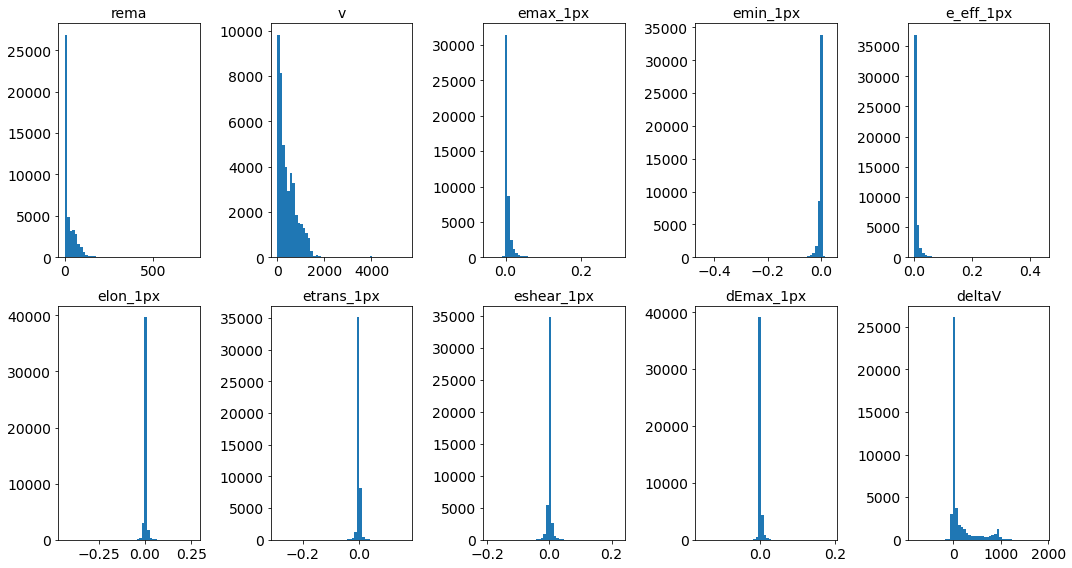

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
xvar_list=['rema', 'v', 'emax_1px', 'emin_1px', 'e_eff_1px', 'elon_1px', 'etrans_1px', 'eshear_1px', 'dEmax_1px', 'deltaV']
# sns.histplot(data_pxs_df[xvar_list[1:]])
# sns.pairplot(data_pxs_ais[xvar_list])

fig,axs=plt.subplots(2,5,figsize=(15,8))
r=0;c=0
for varname in xvar_list:
    # fig,ax=plt.subplots()
    ax=axs[r,c]
    ax.hist(data_pxs_ais[varname],50)
    ax.set_title(varname)
    c+=1
    if c==5:
        r+=1;c=0
fig.tight_layout()